# RL coursework, part IV (30 pts in total)

---

**Name:** Enric Balaguer Rodon

**SN:**

---

**Due date:** *April 11th, 2024*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [237]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-v0_8-notebook')

## Q1 [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency.

In [238]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))

  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [239]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = np.flip(np.cumprod(pi/mu))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G*rho 
  
def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # rho = np.flip(np.cumprod(pi/mu))
  rho = pi/mu
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = rho[t]*(r[t] + d[t]*v[t + 1])
    else:
      G[t] = rho[t]*(r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1]))
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = pi/mu
  for t in reversed(range(T)):
    if t == T-1:
      G[t] = rho[t]*(r[t] + (d[t]*v[t + 1])) + (1-rho[t])*v[t]
    else:
      G[t] = rho[t]*(r[t] + (d[t]*((1-l)*v[t+1] + l*G[t+1]))) + (1-rho[t])*v[t]
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = pi/mu
  lamda = np.minimum(1, 1/rho) #cap lambda
  for t in reversed(range(T)):
    if t == T-1:
      G[t] = lamda[t]*rho[t]*(r[t] + d[t]*v[t + 1]) + (1-(lamda[t]*rho[t]))*v[t]
    else:
      G[t] = lamda[t]*rho[t]*(r[t] + (d[t]*((1-l)*v[t+1] + l*G[t+1]))) + (1-(lamda[t]*rho[t]))*v[t]
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G


In [240]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...

  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right,
  rewards[-1] = np.sum(actions)  # extra final reward for going right

  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities

  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[ 20.6   533.704 166.987   6.004   0.734]


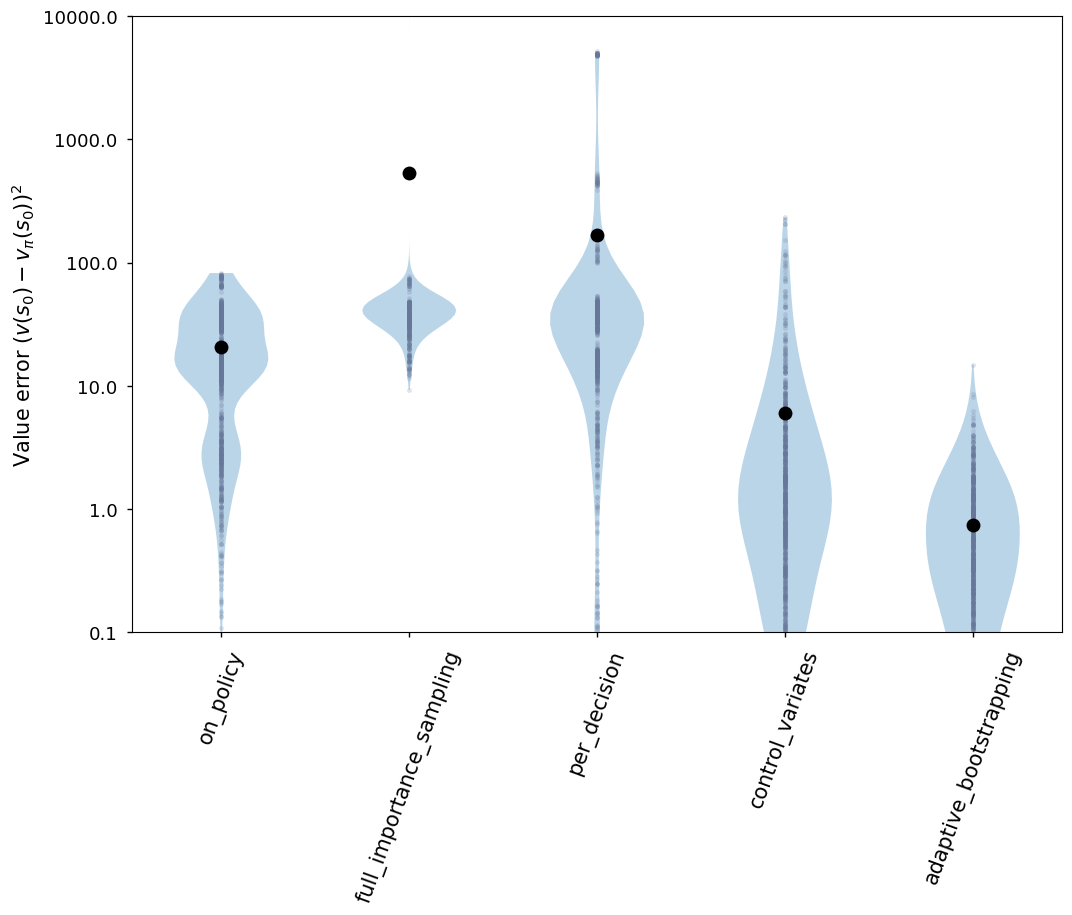

In [241]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

> -Full importance sampling: Worst off-policy return estimate.\
Rho hinders the performance by disproportionally outweighting estimates with actions that are considered to be "outliers". This happens by either heavily weighting estimates with rare actions under behaviour policy but common on the target policy or heavily diminishing estimates with rare actions under target policy but common on behaviour policy. This results in a return estimate with very high variance, as can be appreciated in the plot. The average is so far away from plotted variance due to the "outlier" estimates mentioned above, that have variance so high that does not fit within the plot's y-axis.\
\
-Per decision importance sampling corrections: 2nd Worst off-policy return estimate.\
This off-policy return estimate still does suffer from the "outlier" problem like full importance sampling does but diminishes its impact on performance by implementing the independence of earlier actions from later actions. Since the correction is made "per-step", the trace does not multiply the estimate, reducing variance when compared to full importance sampling.\
\
-Control variates: 2nd Best off-policy return estimate.\
This return estimate sees a big improvement from the past two methods as it does not suffer from the "outlier" estimates anymore. This is accomplished by the addition of the (1-rho[t])*v[t] term. This reduces its variance significantly, being the first off-policy method to outperform on-policy ones.\
\
-Adaptive bootstrapping: Best off-policy return estimate\
This method takes into account the fact that estimates where actions from behaviour policy are rare, but actions from target policy are common heavily influence the variance of the estimate due to the lack of exploration happening in these estimates, thus making them biased. The solution offered by this algorithm is to bootstrap according to this measure, almost fully bootstrapping on "rare to explore again" estimates, thus reducing the bias and in turn the variance of its estimates. This results in the best performing off-policy method, offering the lowest variance.



### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> I can think of a couple reasons. \
\
We may not want to use adaptive bootstrapping due to the possibility of facing the deadly triad. If the rare estimates decribed above (rare behaviour policy actions but common target policy actions) are plenty (not due to action performed by behaviour policy being common, that would defeat the purpose of the method, but by there being a large amount of different rare behaviour-target policy actions), it may cause us to bootstrap too much increasing the possibility of divergence.\
\
At the end of the day, we are acquiring reduced variance on the best methods by imposing bias into the off-policy methods. There might be unexplored environments, where such biases would not be best to apply as an "off the shelf method". Furthermore, for unexplored environments, you might even want a decent amount of variance, as that will allow for more exploration and thus better learning on the long run, for example, to help escape local optima.

## Q2 [19 points total]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

First we have to prove that the T operator is a contraction mapping. T operator with the provided TD update is given by:
$$\begin{align*}
\mathbf{T}q(s, a) &= r(s, a) + \mathbb{E}_{\mu} [\gamma r(s', a') + \gamma^2 \max_{a''} q(s'', a'') | S = s, A = a]\\
&= r(s,a)+ \gamma \mathbb{E}_{s'\sim p(s'|s,a), a'\sim\mu(a'|s')} [r(s',a')] + \mathbb{E}_{s'\sim p(s'|s,a), a'\sim\mu(a'|s'), s''\sim p(s'|s',a')} [\max_{a''} q(s'',a'')] \\
&= r(s,a)+ \gamma \mathbb{E}_{s', a'} [r(s',a')] + \mathbb{E}_{s', a', s''} [\max_{a''} q(s'',a'')]
\end{align*}
$$
Where I re-write expectations in the last line for simplicity's sake.\
\
Now I need to prove $\mathbf{T}q(s, a)$ is a $\gamma$-contraction operator wrt L-infinity norm. For that I show that $|\mathbf{T}q_1 - \mathbf{T}q_2|_{\infty} \leq \gamma||q_1 - q_2||_\infty, \forall q_1, q_2 \in Q$. For that, I first write out $|\mathbf{T}q_1(s, a) - \mathbf{T}q_2(s, a)|$, use Jensen's inequality to move the absolute value inside of the expectation and use maximum properties to pull the max outside of the absolute value.

$$\begin{align*}
|\mathbf{T}q_1(s, a_1) - \mathbf{T}q_2(s, a_2)| &= \gamma^2\left| \mathbb{E}_{s', a', s''} [\max_{a_1''} q_1(s'',a_1'') - \max_{a_2''} q_2(s'',a_2'')] \right| \\
&= \gamma^2\left| \mathbb{E}_{s''} [\max_{a_1''} q_1(s'',a_1'') - \max_{a_2''} q_2(s'',a_2'')] \right| \\
&\leq \gamma^2 \mathbb{E}_{s''} [\left|\max_{a_1''} q_1(s'',a_1'') - \max_{a_2''} q_2(s'',a_2'')\right|] \\
&\leq \gamma^2 \mathbb{E}_{s''} \max_{a''} [\left|q_1(s'',a'') - q_2(s'',a'')\right|] \\
&\leq \gamma^2 \max_{s'', a''} [\left|q_1(s'',a'') - q_2(s'',a'')\right|] \\
\end{align*}$$
Which can be generalized for any action and state, thus acquiring: $|\mathbf{T}q_1(s, a) - \mathbf{T}q_2(s, a)| \leq \gamma\max_{s,a}|[q_1(s,a)-q_2(s,a)]|$.\
\
Now we can apply L-infinity norm on both sides to acquire: $||\mathbf{T}q_1 - \mathbf{T}q_2||_\infty \leq \gamma||q_1 - q_2||_\infty, \forall q_1, q_2 \in Q$.\
\
Thus $\mathbf{T}$ is a $\gamma$ contraction mapping.\
\
Now that we have proven that $\mathbf{T}$ is a $\gamma$ contraction mapping, by Banach Fixed Point Theorem, we know that $\mathbf{T}$ has a unique fixed point $q\in Q : \exist ! q* \in Q s.t. \mathbf{T}q*=q*$. And that the sequence $q_{n+1}=\textbf{T}q_n$ converges to $q*$ (optmial value function) in a geometric fashion in the limit of $n\rightarrow\infty$, no matter the initialisation of the value function.\


ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)\
\
We need two requirements. First, we need an appropriate learning rate, as stated by Robbins-Monro conditions. This is given to us as true in the above subsection. Second, we need the behaviour policy $\mu$ to be greedy in the limit with infinite exploration (GLIE), since we know that converges to $q*$ in the tabular case from lectures. So in summary, the above process converges to the optimal value function $q_*$ if and only if learning rate Robbins-Monro conditions are satisfied and the behaviour policy $\mu$ is greedy in the limit with infinite exploration.


### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q5.1? (3 points).
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

- Answer i)a) In off-policy methods, the behaviour policy must be exploratory, it needs to have infinite exploration for the off-policy method to converge to optimal value functions. Given that behaviour policy is greedy, it is uncapable of exploring, thus failing to visit every state in the limit of $t\rightarrow\infty$. Consequently, the action value function will not converge to its optimal value function $q*$, given our greedy target policy. I just realised while answering below questions, since $\mu=\pi$ in this case, this would be on-policy greedy behaviour, which is not assured to converge due to lack of exploration.
- Answer i)b) Given that the behaviour policy is uniformly random, this will make it so it is infinitely exploring, visiting every state in the MDP an infinite amount of times in the limit of $t\rightarrow\infty$. As such, this will allow our value function to converge to its optimal value function $q*$, given the greedy target policy.\
\
- Answer ii)a) Once again, since $\mu=\pi$, is as is if we were following on-policy greedy behaviour, thus $\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}=1$. As such, we would expect reduced variance wrt 2.1 since its behaviour is off-policy and ours on-policy.
- Answer ii)b) I would expect variance to be increased with such behaviour policy for the same reason the on-policy estimate has less variance than full importance sampling estimate in the above plot in this notebook. As we are doing full importance sampling, with this behaviour policy the rho ratio would be: $\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}=|A|$ for greedy actions (since $\pi=0$ for non-greedy actions). Thus increasing the temporal difference error on every update, as compared to 2.1. ($|A|\geq 1$ always)\
\
- Answer iii) Like we considered above, $\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}=0$ for non-greedy target policy actions and $\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}=\mu^{-1}$ for target policy greedy actions. Since $\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}=1$ for $\mu=\pi$, we need at least a policy that will provide us a smaller rho value than one: $\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}\leq 1$. So we must find a $\mu$ such that: $\mu^{-1}\leq 1 \rightarrow \mu \geq 1$ for any action. Since $\mu$ is a PDF, this can not be, and the best possible $\mu$ is when we acquire equality, meaning when $\mu=\pi$. Therefore, there is no behaviour policy that achieves a lower variance than $\mu=\pi$.